I adapted this notebook template from `DirtyER.ipynb` on the `pyJedAI` GitHub into this NB. I added notes on things that worked and didn't work for me: [link to original notebook](https://github.com/AI-team-UoA/pyJedAI/blob/main/docs/tutorials/DirtyER.ipynb).

We don't have a ground-truth file, so we will have to explore ways to measure the validity of our results. We should do this before we optimize our code against our data set further. 

**Notes**: 
- I kept the original imports so that we can experiment with different methods/stages. I noted import errors that I ran into.
- There are some stages that I performed since they are technically listed as *optional*. Once we have metrics to measure the correctedness our entity relations

In [1]:
!pip install pyjedai

In [2]:
!pip show pyjedai

Name: pyjedai
Version: 0.1.3
Summary: An open-source library that builds powerful end-to-end Entity Resolution workflows.
Home-page: 
Author: 
Author-email: Konstantinos Nikoletos <nikoletos.kon@gmail.com>, George Papadakis <gpapadis84@gmail.com>, Jakub Maciejewski <jacobb.maciejewski@gmail.com>, Manolis Koubarakis <koubarak@di.uoa.gr>
License: Apache Software License 2.0
Location: /Users/javi/anaconda3/lib/python3.9/site-packages
Requires: faiss-cpu, gensim, matplotlib, matplotlib-inline, networkx, nltk, numpy, optuna, ordered-set, pandas, pandas-profiling, pandocfilters, plotly, py-stringmatching, PyYAML, rdflib, rdfpandas, regex, scipy, seaborn, sentence-transformers, strsim, strsimpy, tomli, tqdm, transformers, valentine
Required-by: 


In [3]:
import os
import sys
import pandas as pd
import networkx
from networkx import draw, Graph

In [4]:
from pyjedai.utils import print_clusters, print_blocks, print_candidate_pairs
from pyjedai.evaluation import Evaluation

[nltk_data] Downloading package stopwords to /Users/javi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from pyjedai.datamodel import Data

In [6]:
d1 = pd.read_csv("people.csv")

In [7]:
d1 = d1.set_index('rec_id')

In [8]:
d1.columns

Index([' given_name', ' surname', ' street_number', ' address_1', ' address_2',
       ' suburb', ' postcode', ' state', ' date_of_birth'],
      dtype='object')

In [9]:
d1

given_name     surname  street_number             address_1  \
rec_id                                                                
1         mitchell       green              7         wallaby place   
2           harley    mccarthy            177         pridhamstreet   
3         madeline       mason             54       hoseason street   
4         isabelle                         23         gundulu place   
5           taylor    hathaway              7        yuranigh court   
...            ...         ...            ...                   ...   
4996          jack    campbell            169           marr street   
4997       william    lazaroff             12            leah ylose   
4998      destynii    bowerman             12      halford crescent   
4999        gianni      dooley             38     ashburton circuit   
5000          jake   westbrook            231   booroondar a street   

                      address_2           suburb   postcode  state  \
rec_id                                                               
1                        delmar        cleveland       2119     sa   
2                        milton          marsden       3165    nsw   
3        lakefront retrmnt vlge        granville       4881    nsw   
4                     currin ga         utakarra       2193     wa   
5                brentwood vlge                        4220    nsw   
...                         ...              ...        ...    ...   
4996                   rhosewyn         oakleigh       3356    vic   
4997                   milwlood           forbes       7256    qld   
4998                     sutton        nollamara       2431    qld   
4999             brentwood vlge             ryde       6025    qld   
5000                    jodayne   salisbury east       2074    nsw   

        date_of_birth  
rec_id                 
1            19560409  
2            19080419  
3            19081128  
4            19921119  
5            19991207  
...               ...  
4996         19770109  
4997                   
4998         19880821  
4999         19371212  
5000         19001115  

[5000 rows x 9 columns]

In [10]:
d1['name'] = d1[' given_name'] + ' ' + d1[' surname']
d1 = d1.drop(columns=[' given_name',' surname'])

In [11]:
d1['address'] = d1[' street_number'] + ' ' + d1[' address_1'] + ' ' + d1[' suburb']
d1 = d1.drop(columns=[' street_number',' address_1', ' suburb'])

In [12]:
d1

address_2   postcode  state  date_of_birth  \
rec_id                                                             
1                        delmar       2119     sa       19560409   
2                        milton       3165    nsw       19080419   
3        lakefront retrmnt vlge       4881    nsw       19081128   
4                     currin ga       2193     wa       19921119   
5                brentwood vlge       4220    nsw       19991207   
...                         ...        ...    ...            ...   
4996                   rhosewyn       3356    vic       19770109   
4997                   milwlood       7256    qld                  
4998                     sutton       2431    qld       19880821   
4999             brentwood vlge       6025    qld       19371212   
5000                    jodayne       2074    nsw       19001115   

                       name                                   address  
rec_id                                                                 
1           mitchell  green               7  wallaby place  cleveland  
2          harley  mccarthy               177  pridhamstreet  marsden  
3           madeline  mason            54  hoseason street  granville  
4                isabelle                 23  gundulu place  utakarra  
5          taylor  hathaway                       7  yuranigh court    
...                     ...                                       ...  
4996         jack  campbell                169  marr street  oakleigh  
4997      william  lazaroff                    12  leah ylose  forbes  
4998     destynii  bowerman           12  halford crescent  nollamara  
4999         gianni  dooley               38  ashburton circuit  ryde  
5000        jake  westbrook  231  booroondar a street  salisbury east  

[5000 rows x 6 columns]

In [13]:
col_list = d1.columns.values

In [14]:
col_list

array([' address_2', ' postcode', ' state', ' date_of_birth', 'name',
       'address'], dtype=object)

In [15]:
data = Data(
    dataset_1=d1,
    attributes_1=col_list,
    id_column_name_1=col_list[0]
)

In [16]:
data.print_specs()

------------------------- Data -------------------------
Type of Entity Resolution:  Dirty
Dataset-1:
	Number of entities:  5000
	Number of NaN values:  0
	Attributes: 
		 [' address_2' ' postcode' ' state' ' date_of_birth' 'name' 'address']

Total number of entities:  5000
-------------------------------------------------------- 



## Block Building

In [17]:
from pyjedai.block_building import SuffixArraysBlocking

# from pyjedai.block_building import (
#     StandardBlocking,
#     QGramsBlocking,
#     ExtendedQGramsBlocking,
#     SuffixArraysBlocking,
#     ExtendedSuffixArraysBlocking,
# )

# from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding 


I get errors in this line `from pyjedai.vector_based_blocking import EmbeddingsNNBlockBuilding` 

```
i get tokenizers>=0.11.1,!=0.11.3,<0.14 is required for a normal functioning of this module, but found tokenizers==0.15.0.
```

In [18]:
bb = SuffixArraysBlocking(suffix_length=2)
blocks = bb.build_blocks(data)

Suffix Arrays Blocking:   0%|          | 0/5000 [00:00<?, ?it/s]

## Block Purging

In [19]:
from pyjedai.block_cleaning import BlockPurging

In [20]:
bp = BlockPurging()
cleaned_blocks = bp.process(blocks, data, tqdm_disable=False)

Block Purging:   0%|          | 0/40352 [00:00<?, ?it/s]

In [21]:
bp.report()

Method name: Block Purging
Method info: Discards the blocks exceeding a certain number of comparisons.
Parameters: 
	Smoothing factor: 1.025
	Max Comparisons per Block: 1378.0
Runtime: 0.0955 seconds


## Block Cleaning

In [22]:
from pyjedai.block_cleaning import BlockFiltering

In [23]:
bc = BlockFiltering(ratio=0.9)
blocks = bc.process(blocks, data)

Block Filtering:   0%|          | 0/3 [00:00<?, ?it/s]

## Meta Blocking

In [24]:
from pyjedai.comparison_cleaning import (
    WeightedEdgePruning,
    WeightedNodePruning,
    CardinalityEdgePruning,
    CardinalityNodePruning,
    BLAST,
    ReciprocalCardinalityNodePruning,
    ReciprocalWeightedNodePruning,
    ComparisonPropagation
)

In [25]:
mb = WeightedEdgePruning(weighting_scheme='CBS')
blocks = mb.process(blocks, data)

Weighted Edge Pruning:   0%|          | 0/5000 [00:00<?, ?it/s]

## Entity Matching

In [26]:
from pyjedai.matching import EntityMatching

In [27]:
em = EntityMatching(
    metric='jaccard',
    similarity_threshold=0.0
)

pairs_graph = em.predict(blocks, data)

Entity Matching (jaccard, white_space_tokenizer):   0%|          | 0/4628 [00:00<?, ?it/s]

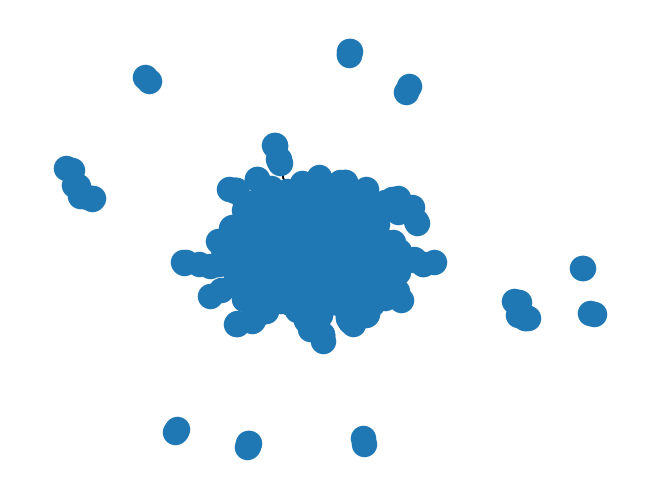

In [28]:
draw(pairs_graph)

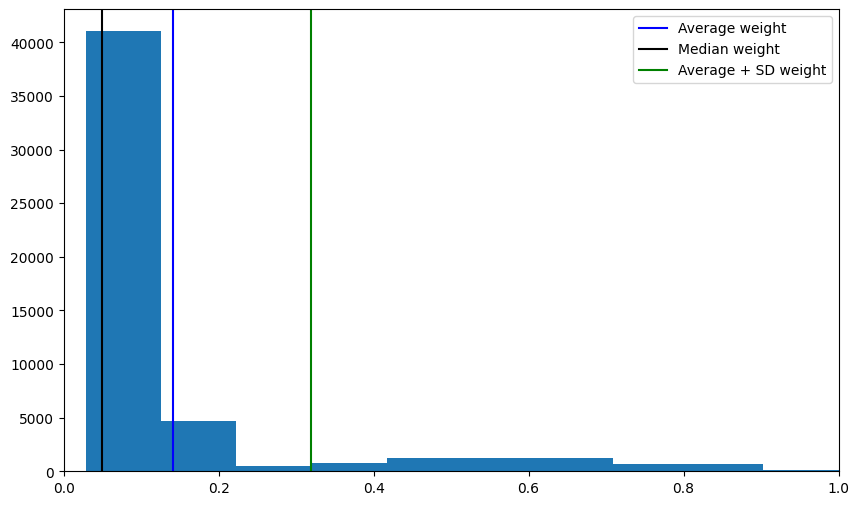

In [29]:
em.plot_distribution_of_all_weights()

Distribution-% of predicted scores:  [59.256000765037776, 27.50310796595582, 1.3847183704695418, 1.2737878932772304, 2.0120493449364063, 2.914793917949699, 2.702495935736827, 1.1781581715597207, 1.4382710146313473, 0.17404609352586783]


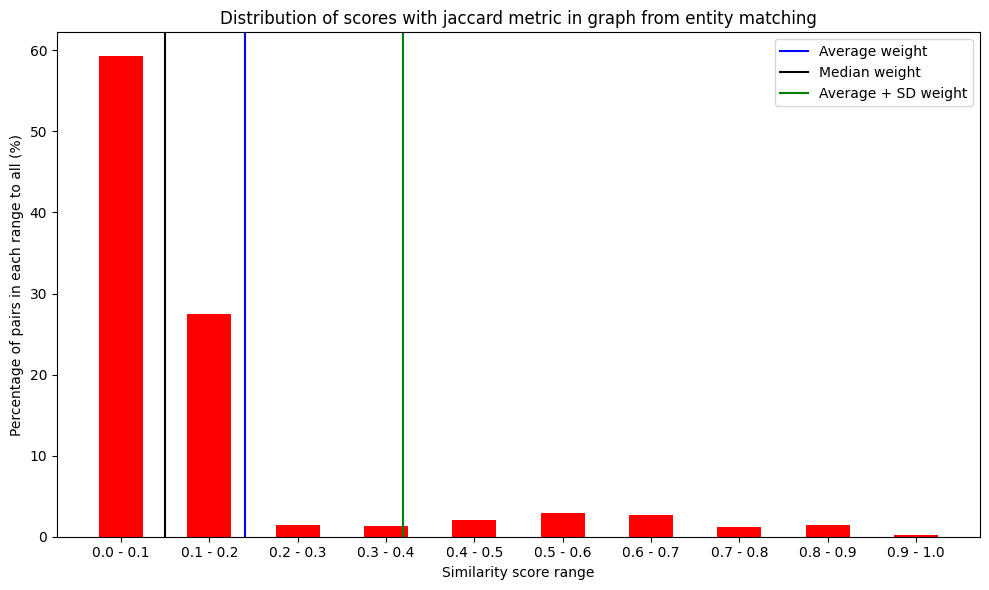

In [30]:
em.plot_distribution_of_scores()

## Entity Clustering

In [31]:
from pyjedai.clustering import ConnectedComponentsClustering

In [32]:
ec = ConnectedComponentsClustering()
clusters = ec.process(pairs_graph, data, similarity_threshold=0.5)

In [33]:
len(clusters)

2273

In [34]:
d1['cluster_id'] = None

In [35]:
d1

address_2   postcode  state  date_of_birth  \
rec_id                                                             
1                        delmar       2119     sa       19560409   
2                        milton       3165    nsw       19080419   
3        lakefront retrmnt vlge       4881    nsw       19081128   
4                     currin ga       2193     wa       19921119   
5                brentwood vlge       4220    nsw       19991207   
...                         ...        ...    ...            ...   
4996                   rhosewyn       3356    vic       19770109   
4997                   milwlood       7256    qld                  
4998                     sutton       2431    qld       19880821   
4999             brentwood vlge       6025    qld       19371212   
5000                    jodayne       2074    nsw       19001115   

                       name                                   address  \
rec_id                                                                  
1           mitchell  green               7  wallaby place  cleveland   
2          harley  mccarthy               177  pridhamstreet  marsden   
3           madeline  mason            54  hoseason street  granville   
4                isabelle                 23  gundulu place  utakarra   
5          taylor  hathaway                       7  yuranigh court     
...                     ...                                       ...   
4996         jack  campbell                169  marr street  oakleigh   
4997      william  lazaroff                    12  leah ylose  forbes   
4998     destynii  bowerman           12  halford crescent  nollamara   
4999         gianni  dooley               38  ashburton circuit  ryde   
5000        jake  westbrook  231  booroondar a street  salisbury east   

       cluster_id  
rec_id             
1            None  
2            None  
3            None  
4            None  
5            None  
...           ...  
4996         None  
4997         None  
4998         None  
4999         None  
5000         None  

[5000 rows x 7 columns]

In [40]:
for cluster_id, cluster in enumerate(clusters):
    valid_indices = [idx for idx in cluster if idx in d1.index]
    d1.loc[valid_indices, 'cluster_id'] = cluster_id


In [41]:
d1

address_2   postcode  state  date_of_birth  \
rec_id                                                             
1                        delmar       2119     sa       19560409   
2                        milton       3165    nsw       19080419   
3        lakefront retrmnt vlge       4881    nsw       19081128   
4                     currin ga       2193     wa       19921119   
5                brentwood vlge       4220    nsw       19991207   
...                         ...        ...    ...            ...   
4996                   rhosewyn       3356    vic       19770109   
4997                   milwlood       7256    qld                  
4998                     sutton       2431    qld       19880821   
4999             brentwood vlge       6025    qld       19371212   
5000                    jodayne       2074    nsw       19001115   

                       name                                   address  \
rec_id                                                                  
1           mitchell  green               7  wallaby place  cleveland   
2          harley  mccarthy               177  pridhamstreet  marsden   
3           madeline  mason            54  hoseason street  granville   
4                isabelle                 23  gundulu place  utakarra   
5          taylor  hathaway                       7  yuranigh court     
...                     ...                                       ...   
4996         jack  campbell                169  marr street  oakleigh   
4997      william  lazaroff                    12  leah ylose  forbes   
4998     destynii  bowerman           12  halford crescent  nollamara   
4999         gianni  dooley               38  ashburton circuit  ryde   
5000        jake  westbrook  231  booroondar a street  salisbury east   

       cluster_id  
rec_id             
1             223  
2               1  
3              16  
4             127  
5             365  
...           ...  
4996         2272  
4997          904  
4998          408  
4999          631  
5000         None  

[5000 rows x 7 columns]

In [42]:
d1[pd.notnull(d1['cluster_id'])].head(20)

address_2   postcode  state  date_of_birth  \
rec_id                                                             
1                        delmar       2119     sa       19560409   
2                        milton       3165    nsw       19080419   
3        lakefront retrmnt vlge       4881    nsw       19081128   
4                     currin ga       2193     wa       19921119   
5                brentwood vlge       4220    nsw       19991207   
6                 kersey' south       3107    nsw       19940503   
7                                     7310    vic       19721113   
8              telemon orchards       4670    nsw       19751220   
9              kilvintonvillage       4030              19251130   
10                     condinup       4211    vic       19671229   
11             pacific terraces       3101    vic       19940825   
12                    erinsavle       6207    vic       19760517   
13             mackinnon street       6052              19200417   
14                   rowethorpe       3183    nsw       19320907   
15       newman medicajl centre       2535    qld       19910111   
16                        pinds       2478    nsw       19231019   
17       jewells medical centre       3161    qld       19971229   
18                  the willows       2285    vic       19761017   
19                                    3220              19231110   
20                  crown allot       4217    qld       19930714   

                            name                              address  \
rec_id                                                                  
1                mitchell  green          7  wallaby place  cleveland   
2               harley  mccarthy          177  pridhamstreet  marsden   
3                madeline  mason       54  hoseason street  granville   
4                     isabelle            23  gundulu place  utakarra   
5               taylor  hathaway                  7  yuranigh court     
6                     toby  webb             6  kent street  towradgi   
7                   harry  stubs           mountain creek road  eaton   
8               lydia  mccattmhy         32  mckillop ecircuit  corio   
9        hollie  lillie-hinrichs         27  hemmings crescent  banyo   
10                   dylan  zilm      17  blameycrescent  wattle glen   
11                     donaldson         14  manity court  charmhaven   
12             isabella  vincent         16  wilshiredstreet  rose ay   
13                connor  bishop                  27  jarreah  aspley   
14              connor  shepherd      39  burnage place  winstonhills   
15                natalia  gredn     358  macrossan crescent  yagoona   
16           georgia  pettigrove          5  sinclair street  prairei   
17                 wilson  pitno       11  bousteadcircuit  granville   
18               andrew  klander  20  newman morris circuit  homebush   
19                  tahni  skeen        11  macfarland crescent  ryde   
20                 kasey  millar           burdekin avenue  woollahra   

       cluster_id  
rec_id             
1             223  
2               1  
3              16  
4             127  
5             365  
6             254  
7             159  
8             202  
9             982  
10            236  
11            241  
12            151  
13             45  
14              3  
15             93  
16              0  
17              2  
18            601  
19            116  
20            149

In [43]:
d1.to_csv('jedai.csv', index=True)